### Пример рекуррентной нейронной сети lstm для классификации MNIST

In [1]:
import tensorflow as tf
from tensorflow.python.ops import rnn, rnn_cell
from tensorflow.contrib import rnn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
mnist = input_data.read_data_sets('/tmp/data/', one_hot = True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


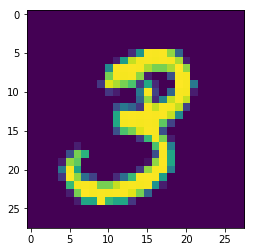

In [4]:
plt.imshow(mnist.train.images[1].reshape(28,28))

In [5]:
n_classes = 10
batch_size = 128
epochs = 10
chunk_size = 28
n_chunks = 28
rnn_size = 128

In [6]:
# hight * width
x = tf.placeholder('float',[None, n_chunks, chunk_size])
y = tf.placeholder('float')

In [7]:
def NN_model(x):
    # imput_data * weights + biases
    layer = {'weights':tf.Variable(tf.random_normal([rnn_size, n_classes])),
             'biases':tf.Variable(tf.random_normal([n_classes]))}
    
    # преобразование датасета к правильному размеру(28*batch_size*28)
    # lstm от tensorflow ест сэмплы именно в таком виде
    x = tf.transpose(x, [1,0,2])
    x = tf.reshape(x, [-1, chunk_size])
    x = tf.split(x, n_chunks, 0)
    
    #1-слойная lstm сеть с 128 скрытыми состояниями
    lstm_cell = rnn_cell.BasicLSTMCell(rnn_size)
    outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)
    
    # output = layer_4 * weights_output + biases_output
    output = tf.matmul(outputs[-1], layer['weights']) + layer['biases']
    
    return output
    

In [8]:
def train_NN(x):
    predict = NN_model(x)
    # softmax нормализует полученные веса output слоя(сумма всех значений = 1)
    # cross_entropy_with_logits высчитывает ошибку для многоклассовой классификации
    # ошибка вычисляется как distance(softmax(outputs), Labels)) = -summ(Labels * log(outputs))
    # нaм нужно минимизировать эту ошибку
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = predict, labels = y))
    
    # оптимизатор(улучшенный стохастический градиентный спуск)
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    
    
    with tf.Session() as session:
        # инициализируем граф со всеми переменными
        session.run(tf.initialize_all_variables())
        
        for epoch in range(epochs):
            epoch_loss = 0
            for _ in range(int(mnist.train.num_examples/batch_size)):
                epoch_x, epoch_y = mnist.train.next_batch(batch_size)
                epoch_x = epoch_x.reshape((batch_size, n_chunks, chunk_size))
                # на каждой эпохе оптимизируем ошибку для каждой части выборки 
                _, c = session.run([optimizer, cost], feed_dict={x:epoch_x, y:epoch_y})
                epoch_loss += c
            print('epoch', epoch, 'complited out of', epochs, 'loss:', epoch_loss)
       
        # считаем метрику accuracy
        correct = tf.equal(tf.argmax(predict, 1), tf.argmax(y, 1))
        
        accuracy = tf.reduce_mean(tf.cast(correct,'float'))
        print( 'accuracy:', accuracy.eval({x:mnist.test.images.reshape((-1, n_chunks, chunk_size)), y:mnist.test.labels}))
            
train_NN(x)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
epoch 0 complited out of 10 loss: 195.089896597
epoch 1 complited out of 10 loss: 57.0894434415
epoch 2 complited out of 10 loss: 39.6309488043
epoch 3 complited out of 10 loss: 29.9862134126
epoch 4 complited out of 10 loss: 25.3992832983
epoch 5 complited out of 10 loss: 21.2556134267
epoch 6 complited out of 10 loss: 18.3713042599
epoch 7 complited out of 10 loss: 15.506275977
epoch 8 complited out of 10 loss: 14.3855932602
epoch 9 complited out of 10 loss: 12.4518984832
accuracy: 0.9835
